In [1]:
import os
import glob
import random
import pandas as pd

def select_random_signals(path, N):
    """
    Select N random signals and return their data from 4 channels.
    
    :param path: The base directory where channel subdirectories are located.
    :param N: The number of random signals to select.
    :return: A list of signals, each represented by data from its 4 channels.
    """
    channels = glob.glob(os.path.join(path, "*/"))
    channels.sort()  # Ensure a consistent order of channels
    
    # Determine the total number of signals by counting files in one channel
    sample_files = glob.glob(os.path.join(channels[0], "*.parquet"))
    total_signals = len(sample_files)
    
    # Randomly select N unique signal numbers
    selected_signal_numbers = random.sample(range(1, total_signals + 1), N)
    
    selected_signals_data = []
    for num in selected_signal_numbers:
        signal_data = []
        for channel in channels:
            file_name = f"File_{num}.parquet"
            signal_file_path = os.path.join(channel, file_name)
            
            if os.path.exists(signal_file_path):
                # Read the Parquet file and append the DataFrame to the signal_data list
                df = pd.read_parquet(signal_file_path)
                signal_data.append(df)
            else:
                print(f"File not found: {signal_file_path}")
                # Optionally, handle missing files (e.g., append None or an empty DataFrame)
                signal_data.append(None)
                
        # Append the list of DataFrames (one per channel) for the current signal to the results list
        selected_signals_data.append(signal_data)
    
    return selected_signals_data


In [2]:
%matplotlib notebook

In [3]:
TH = 1.0

In [4]:
data_path = './Raw_data_test/'
signals = select_random_signals(path=data_path, N=2)

In [5]:
import matplotlib.pyplot as plt

def plot_signals(signals_data):
    """
    Plot all signals, where each signal includes data from 4 channels.
    
    :param signals_data: A list of signals, each a list of pandas.DataFrame objects containing channel data.
    """
    # Define channel names for better readability in the plots
    channel_names = [
        "Trigger (Machine)",
        "Flat Response Microphone (Front)",
        "Flat Response Microphone (Rear)",
        "Resonant Microphone"
    ]
    
    # Iterate over each signal in the signals_data list
    for i, signal in enumerate(signals_data):
        # Create a figure for the current signal
        fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
        fig.suptitle(f'Signal {i+1}', fontsize=16)
        plt.subplots_adjust(hspace=0.5)  # Adjust space between plots
        
        # Iterate over each channel's DataFrame within the signal
        for j, df in enumerate(signal):
            if df is not None:
                # Assuming the data to be plotted is in the first column of the DataFrame
                axs[j].plot(df.iloc[:, 0])
                axs[j].set_title(channel_names[j])
                axs[j].set_ylabel('Amplitude')
            else:
                axs[j].set_title(f'{channel_names[j]} - Data Not Available')
        
        axs[-1].set_xlabel('Sample Index')  # Only set x label on the last subplot to avoid clutter
        
        plt.show()


<IPython.core.display.Javascript object>


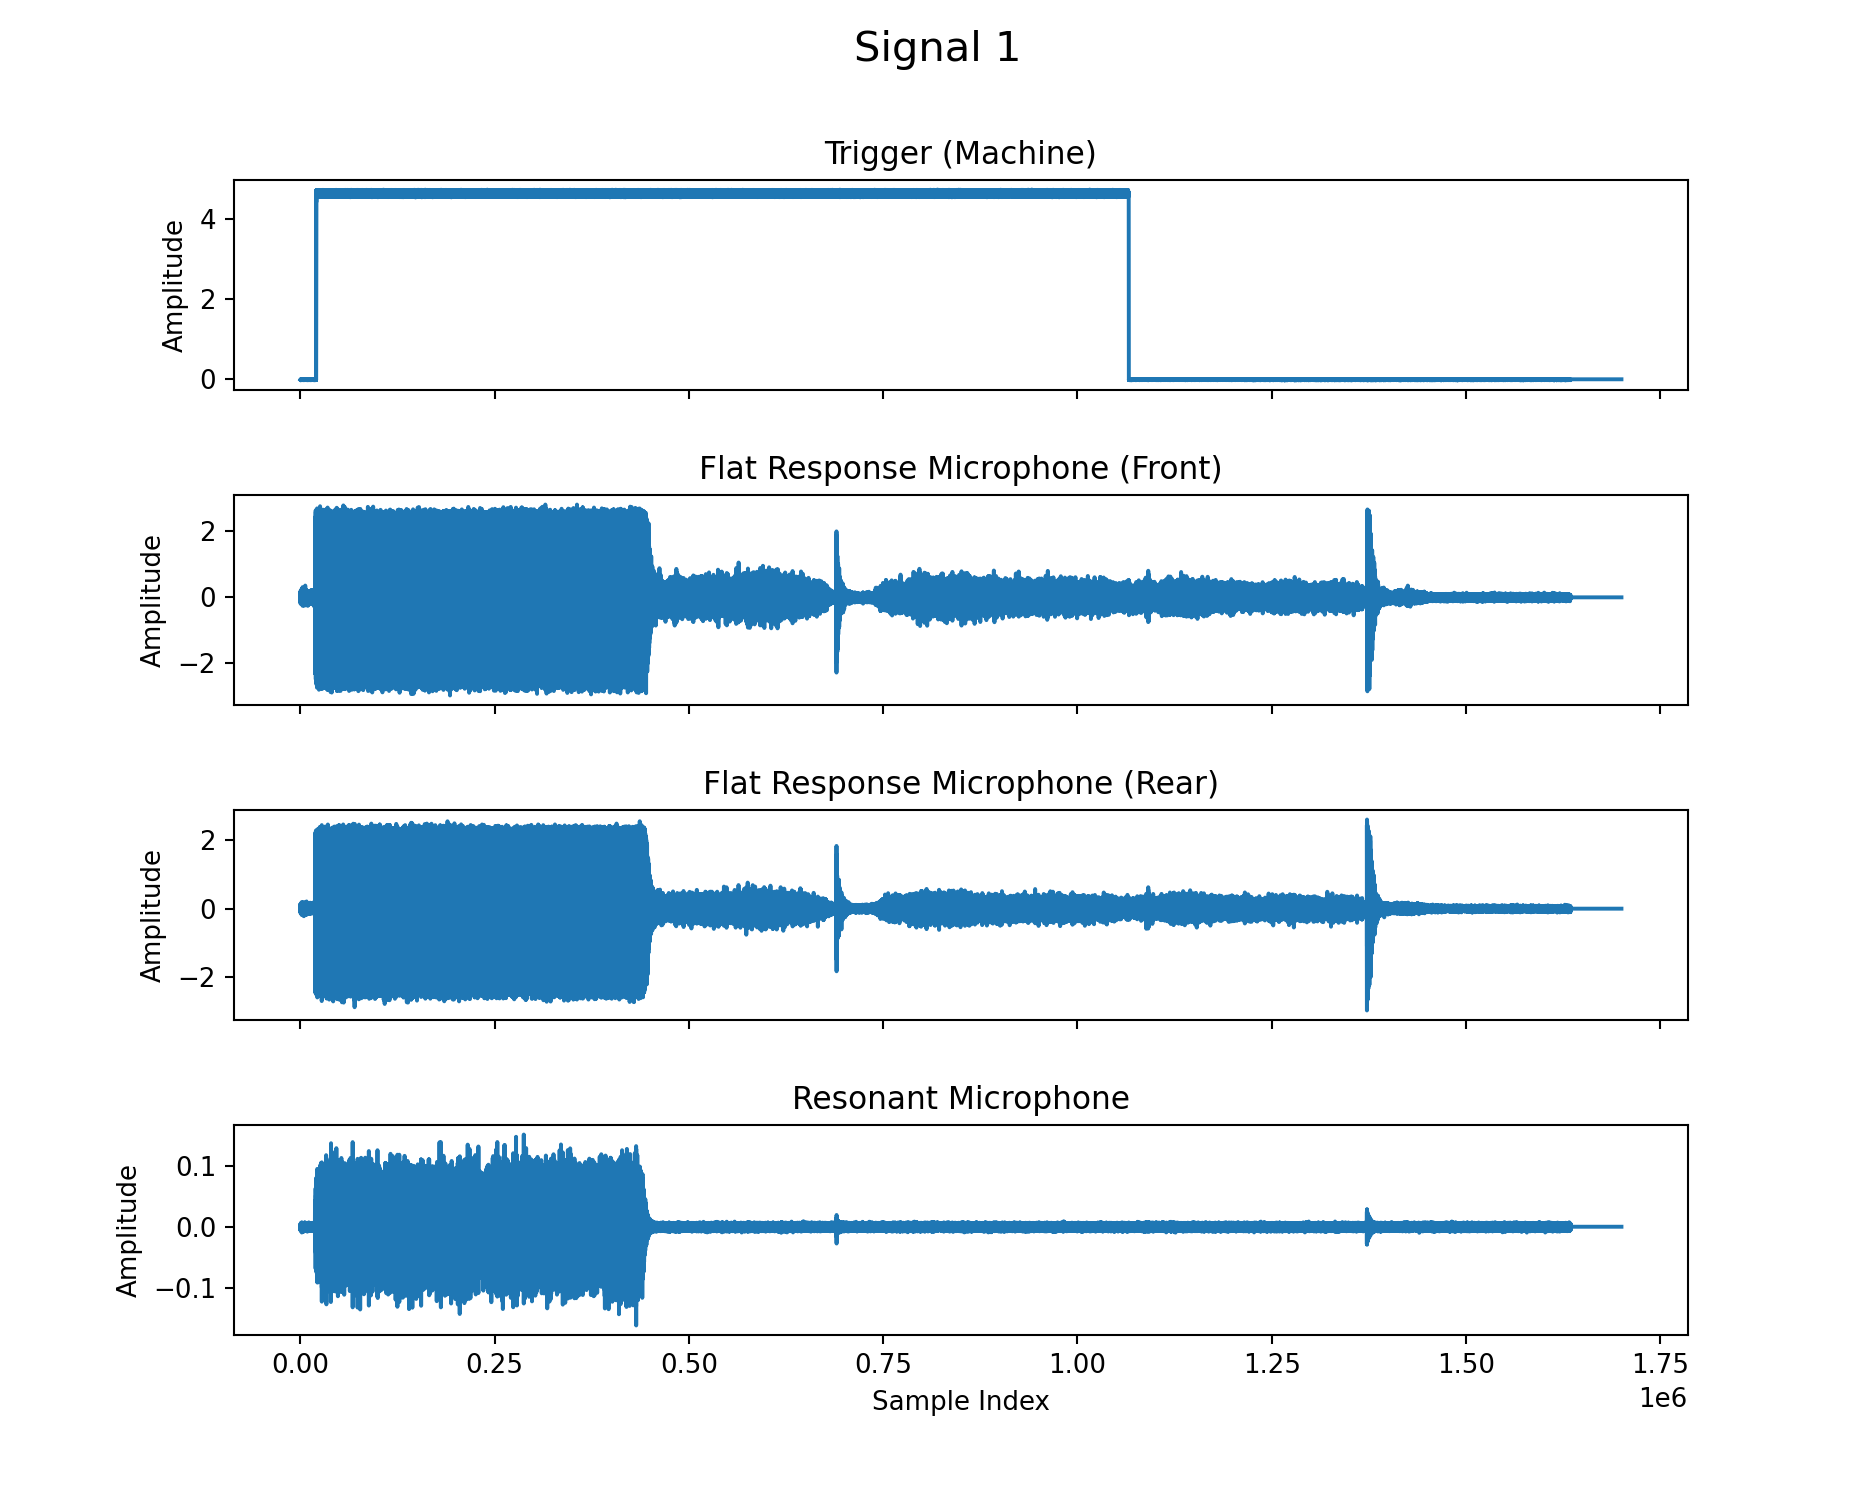

<IPython.core.display.Javascript object>


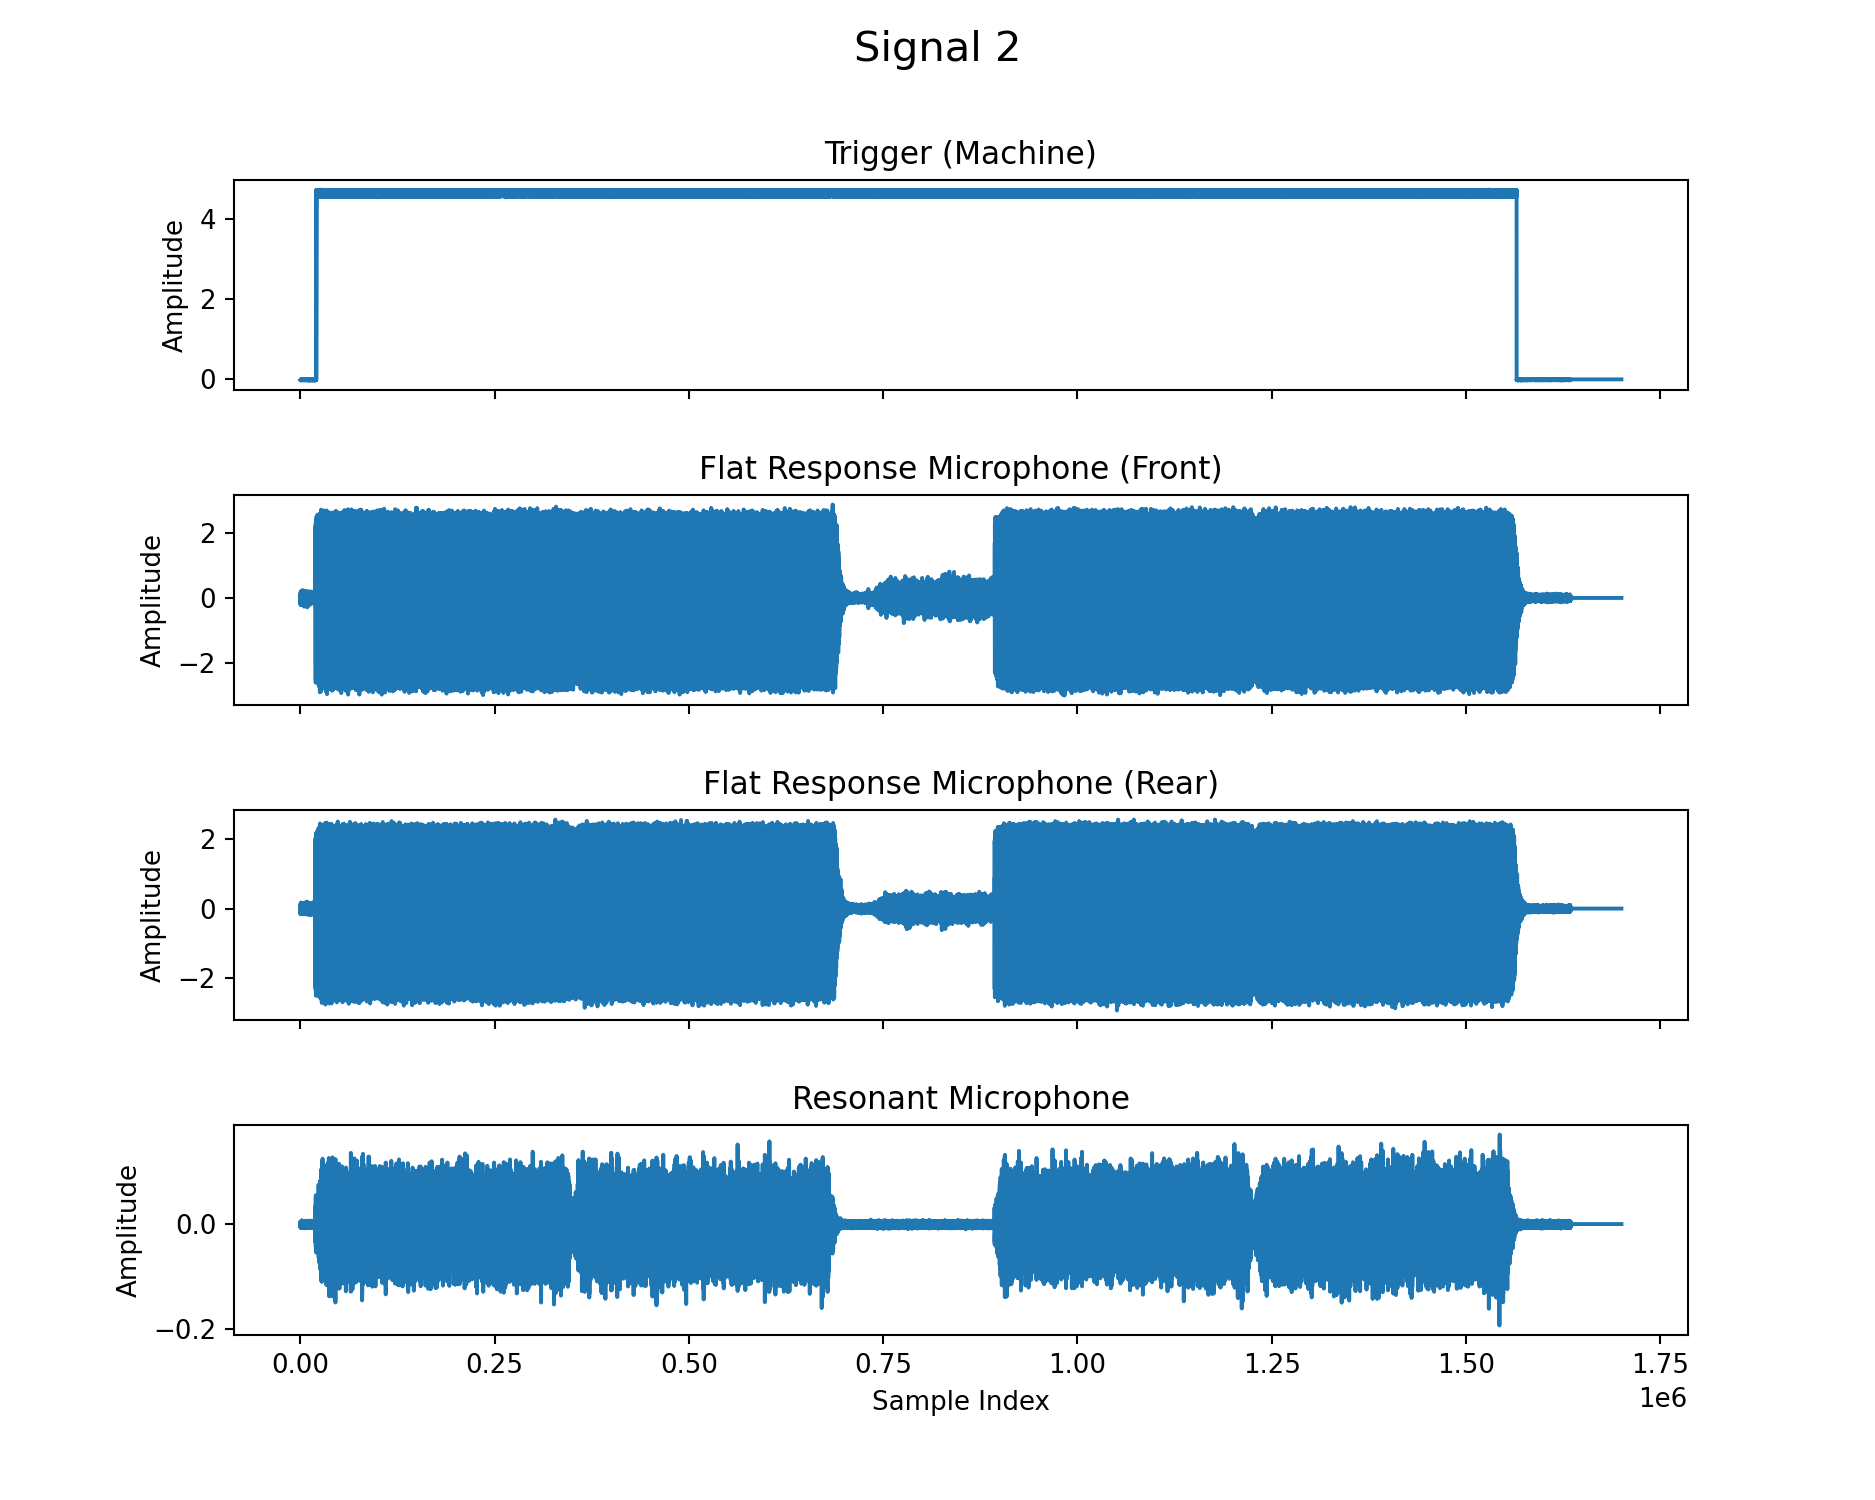

In [6]:
plot_signals(signals)

In [7]:
def computeBoundaries(signal, th):
    # Identify locations where the signal is greater than the threshold
    locs = np.where(signal > th)[0]

    # Create an array of zeros and assign 1 to the identified locations
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    # Perform morphological closing and opening operations on the indexes array
    selem = np.ones((1300, 1)) #70,1
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    # Identify locations where the opened array has 1's
    locsNew = np.where(opened == 1)[0]

    # Compute the difference between adjacent elements of locsNew
    derNew = np.diff(locsNew)

    # Find indices where the difference is greater than 1
    ind = np.where(derNew > 1)[0]

    # Compute starting and ending indices of the sections
    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

In [8]:
import numpy as np
import skimage.morphology

def plot_signals_with_boundaries(signals_data, threshold):
    """
    Plot all signals and their boundaries, where each signal includes data from 4 channels.
    
    :param signals_data: A list of signals, each a list of pandas.DataFrame objects containing channel data.
    :param threshold: The threshold value to use for boundary detection.
    """
    channel_names = [
        "Trigger (Machine)",
        "Flat Response Microphone (Front)",
        "Flat Response Microphone (Rear)",
        "Resonant Microphone"
    ]
    
    for i, signal in enumerate(signals_data):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        fig.suptitle(f'Signal {i+1}', fontsize=16)
        plt.subplots_adjust(hspace=0.5)
        
        # To store the boundaries for the third channel
        third_channel_boundaries = None
        
        for j, df in enumerate(signal):
            if df is not None:
                signal_data = df.iloc[:, 0].values  # data to plot is in the first column
                
                # Compute the absolute value of the signal data
                abs_signal_data = np.abs(signal_data)
                
                # For the last channel, use the third channel's boundaries
                if j == 3 and third_channel_boundaries is not None:
                    starting, ending = third_channel_boundaries
                else:
                    # Compute boundaries
                    starting, ending = computeBoundaries(abs_signal_data, threshold)
                    if j == 2:  # Save the third channel's boundaries
                        third_channel_boundaries = (starting, ending)
                
                # Plot the signal data
                axs[j].plot(signal_data, label=f'Channel {j}')
                
                # Plot boundaries
                axs[j].scatter(starting, signal_data[starting], color='g', label='Starting', zorder=5)
                axs[j].scatter(ending, signal_data[ending], color='r', label='Ending', zorder=5)
                axs[j].legend()
                
                axs[j].set_title(channel_names[j])
                axs[j].set_ylabel('Amplitude')
            else:
                axs[j].set_title(f'{channel_names[j]} - Data Not Available')
        
        axs[-1].set_xlabel('Sample Index')
        
        plt.show()

<IPython.core.display.Javascript object>


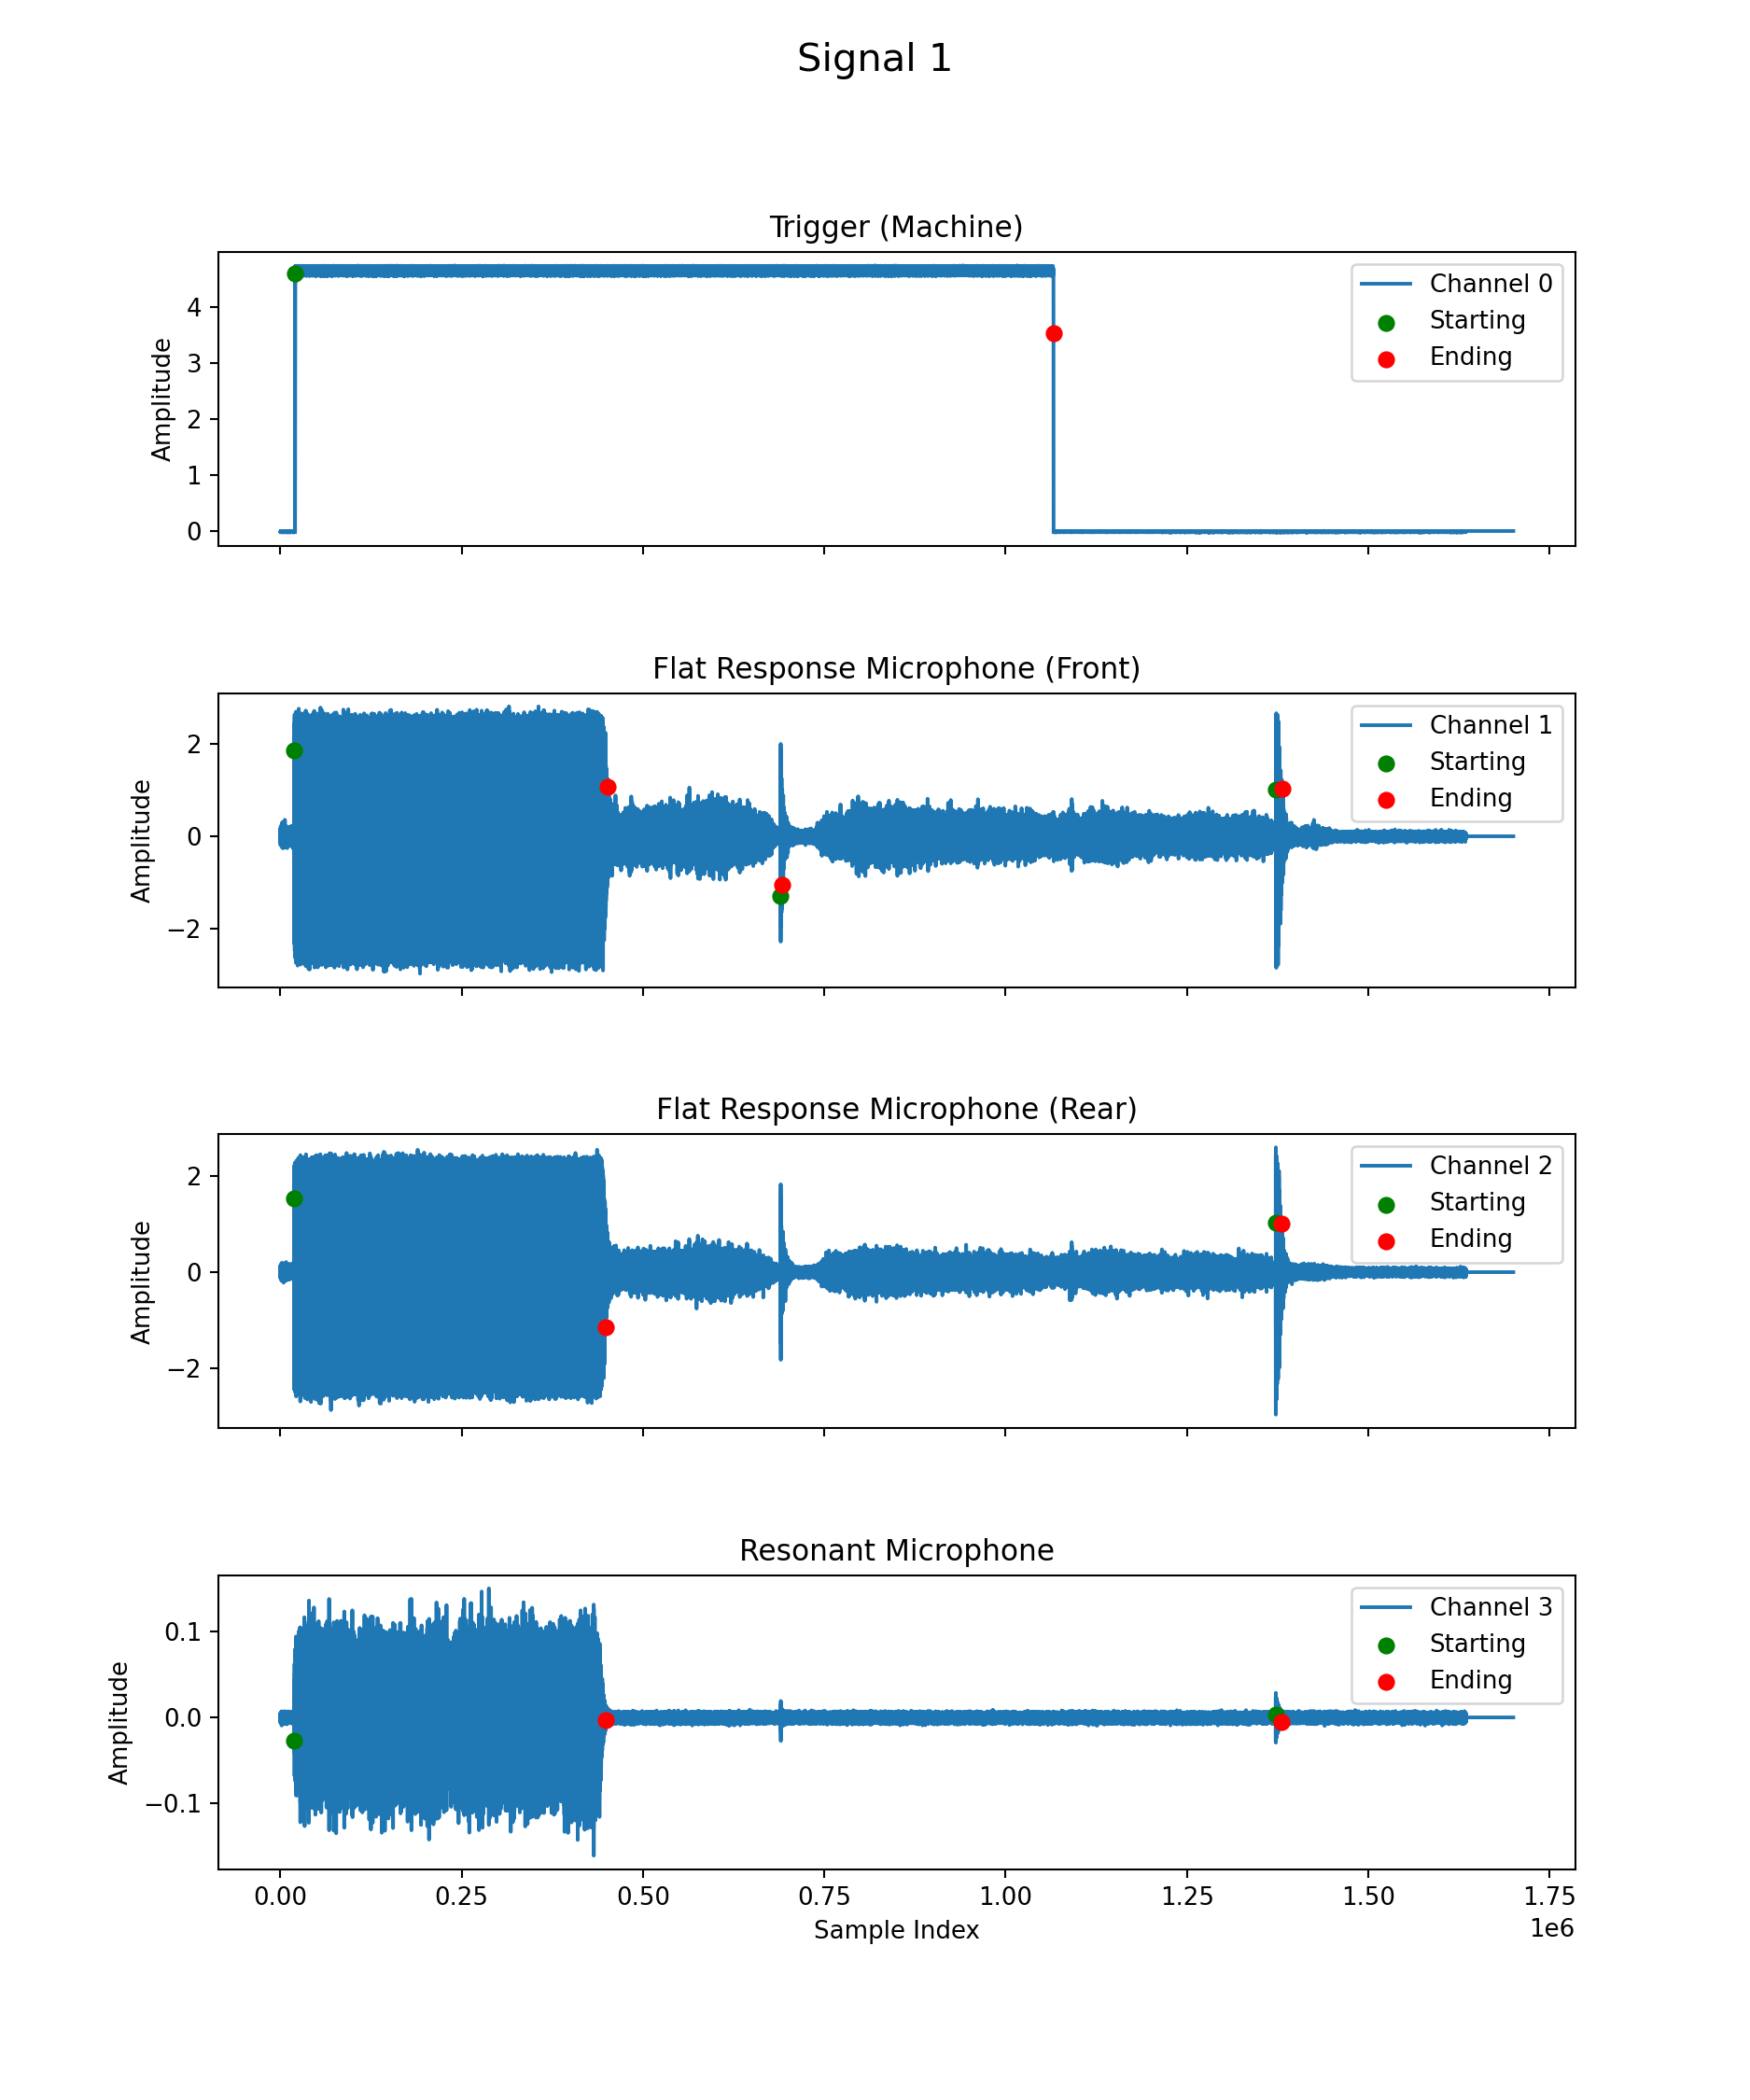

<IPython.core.display.Javascript object>


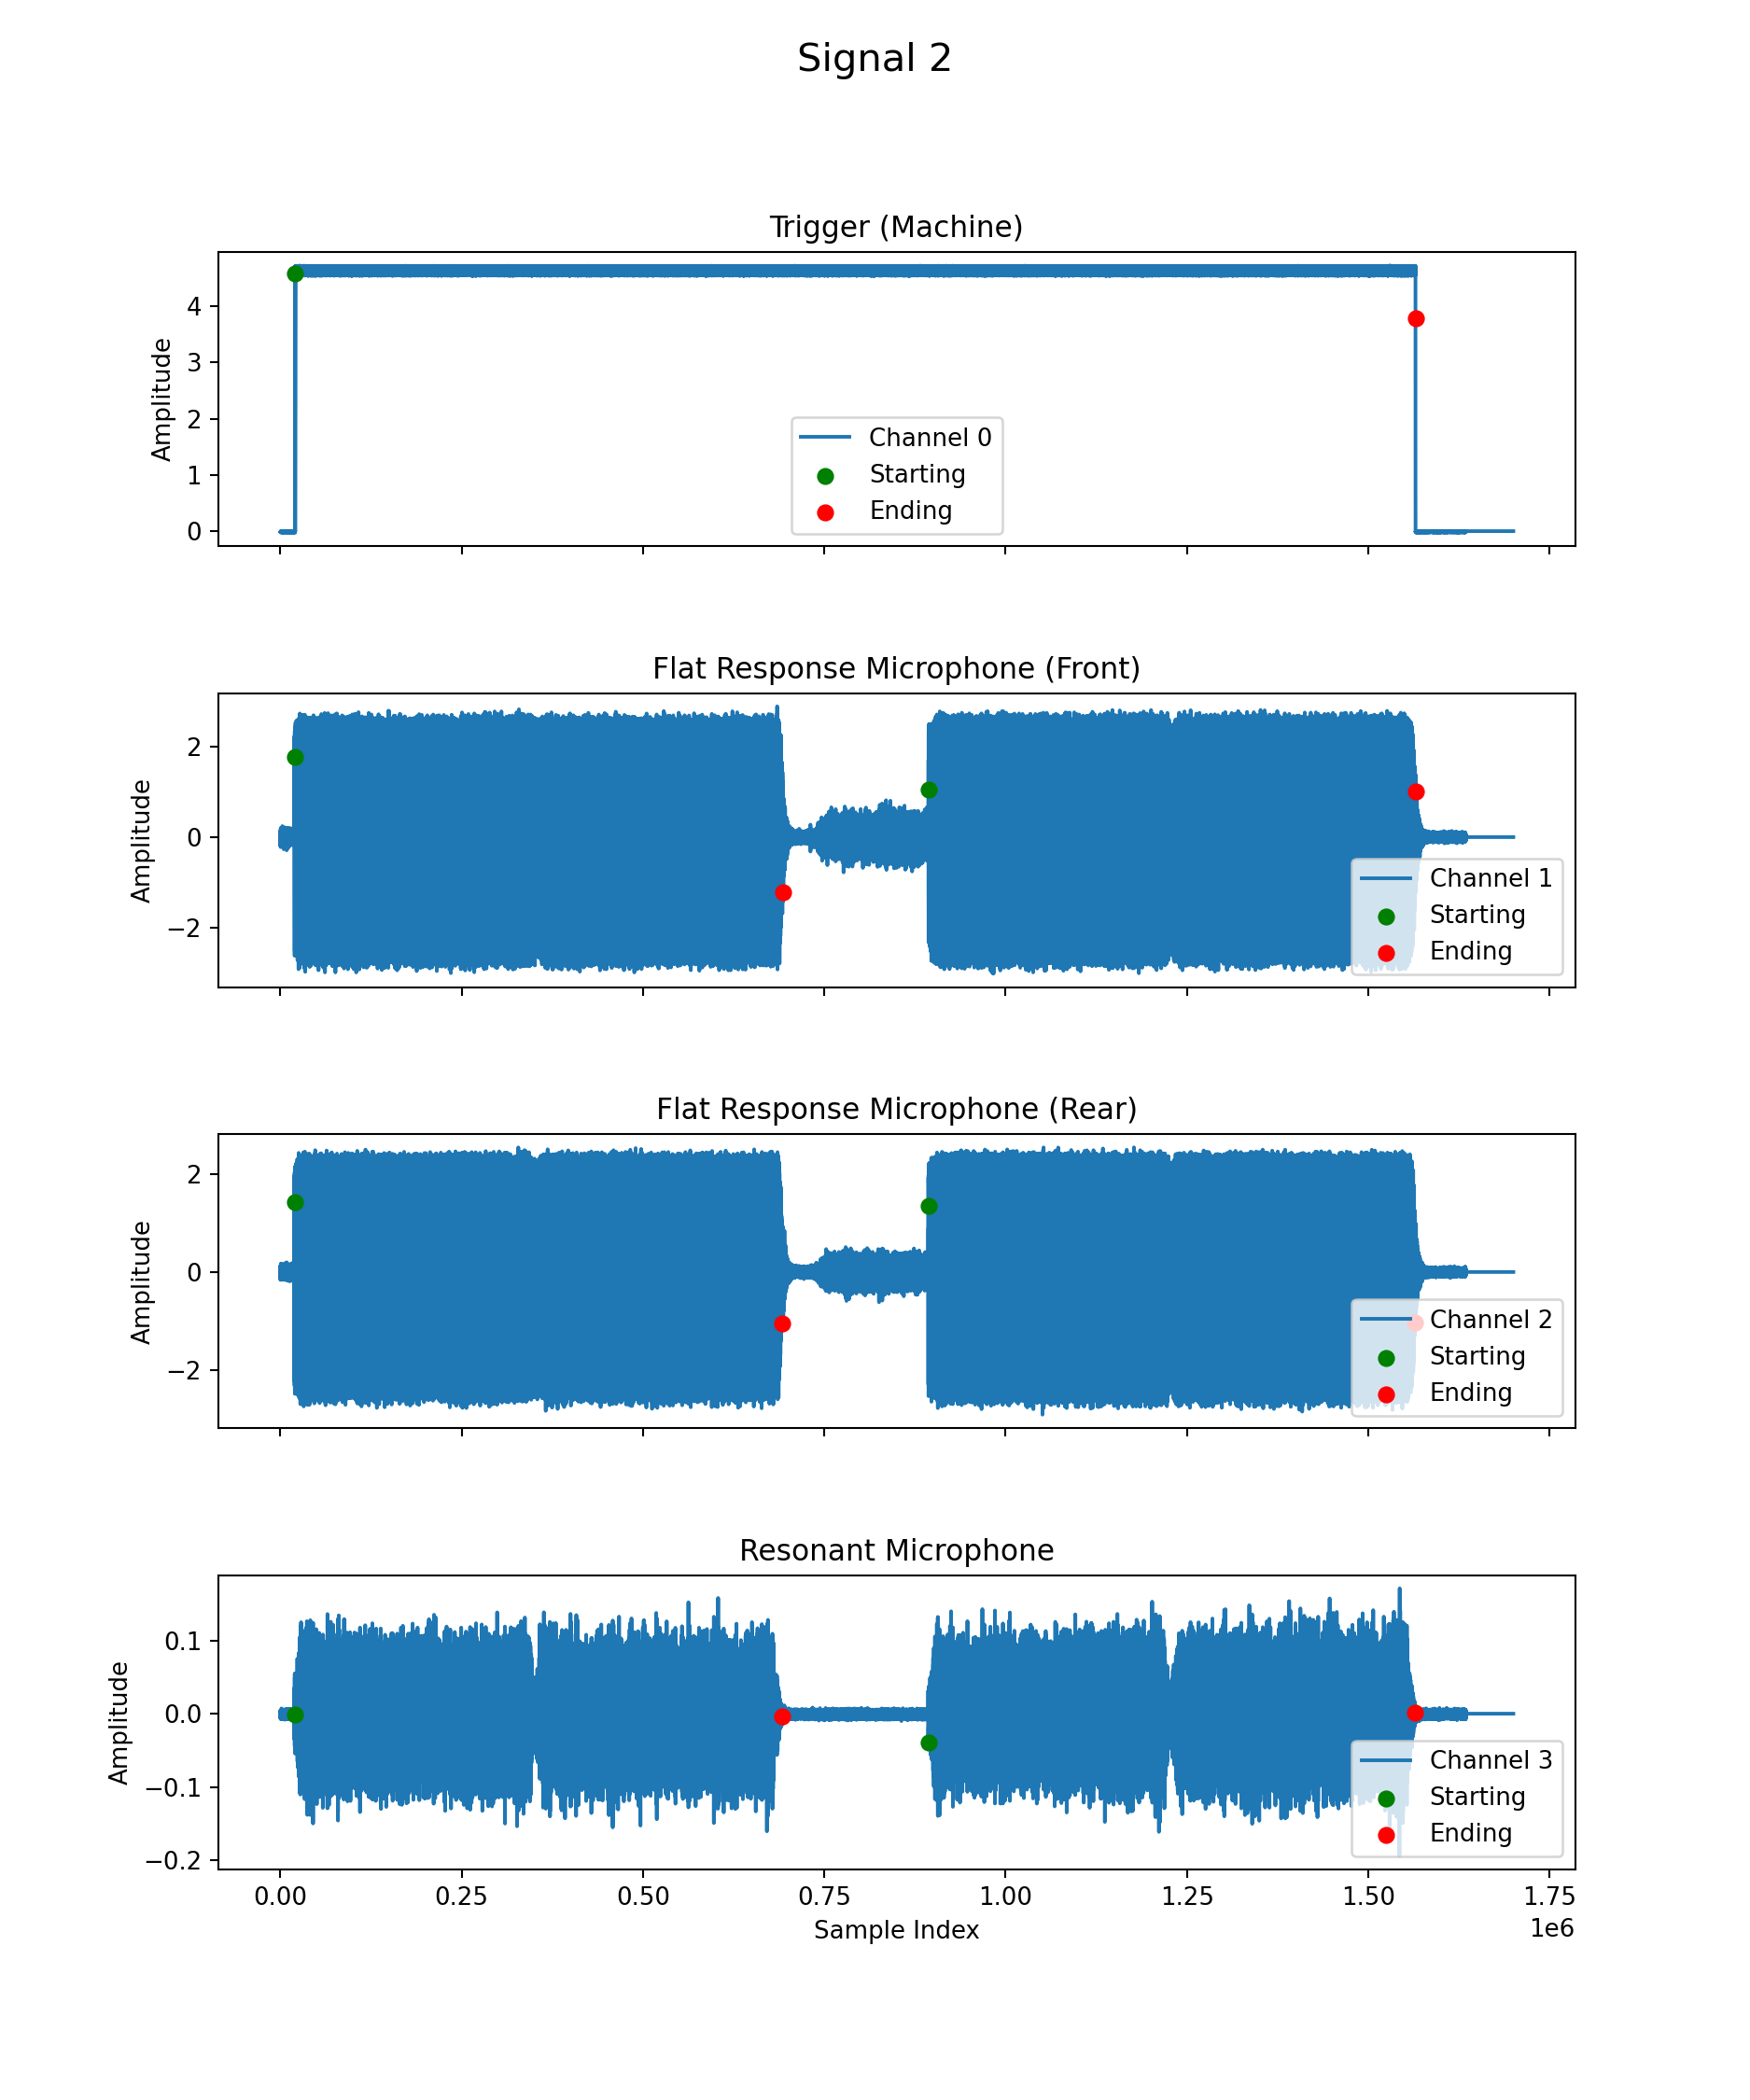

In [9]:
plot_signals_with_boundaries(signals, threshold=TH)

In [12]:
def compute_segment_lengths(starting, ending):
    return ending - starting

def compute_statistics(lengths):
    average = np.mean(lengths)
    std_dev = np.std(lengths)
    return average, std_dev

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.morphology

def compute_large_gaps(starting, ending, gap_threshold=1300):
    """
    Compute the number of large gaps between segments.
    
    :param starting: Array of starting indices for segments.
    :param ending: Array of ending indices for segments.
    :param gap_threshold: The threshold above which a gap is considered large.
    :return: The number of large gaps.
    """
    # Calculate the gaps by subtracting the ending indices of the current segment
    # from the starting indices of the next segment
    gaps = starting[1:] - ending[:-1]
    # Count how many gaps are larger than the threshold
    large_gaps = np.sum(gaps > gap_threshold)
    return large_gaps

def plot_signals_with_boundaries_stats_and_gaps(signals_data, threshold):
    """
    Plot all signals, their boundaries, compute statistics for segment lengths,
    and calculate the number of large gaps, excluding Channel 0 from aggregated statistics.
    
    :param signals_data: A list of signals, each a list of pandas.DataFrame objects containing channel data.
    :param threshold: The threshold value to use for boundary detection.
    """
    channel_names = [
        "Trigger (Machine)",
        "Flat Response Microphone (Front)",
        "Flat Response Microphone (Rear)",
        "Resonant Microphone"
    ]
    
    all_signals_segment_lengths_excl_ch0 = []
    all_signals_large_gaps_excl_ch0 = 0  # Initialize a counter for all large gaps excluding Channel 0
    
    for i, signal in enumerate(signals_data):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        fig.suptitle(f'Signal {i+1}', fontsize=16)
        plt.subplots_adjust(hspace=0.5)
        
        third_channel_boundaries = None
        signal_segment_lengths_excl_ch0 = []
        signal_large_gaps_excl_ch0 = 0  # Initialize a counter for large gaps in the current signal excluding Channel 0
        
        for j, df in enumerate(signal):
            if df is not None:
                signal_data = df.iloc[:, 0].values
                abs_signal_data = np.abs(signal_data)
                
                if j == 3 and third_channel_boundaries is not None:
                    starting, ending = third_channel_boundaries
                else:
                    starting, ending = computeBoundaries(abs_signal_data, threshold)
                    if j == 2:
                        third_channel_boundaries = (starting, ending)
                
                segment_lengths = compute_segment_lengths(starting, ending)
                large_gaps = compute_large_gaps(starting, ending)
                
                if j != 0:
                    signal_segment_lengths_excl_ch0.extend(segment_lengths)
                    all_signals_segment_lengths_excl_ch0.extend(segment_lengths)
                    signal_large_gaps_excl_ch0 += large_gaps
                    all_signals_large_gaps_excl_ch0 += large_gaps
                
                avg_length, std_dev = compute_statistics(segment_lengths)
                print(f"Channel {j} ({channel_names[j]}): Avg Segment Length = {avg_length:.2f}, Std Dev = {std_dev:.2f}, Large Gaps = {large_gaps}")
                
                axs[j].plot(signal_data, label=f'Channel {j}')
                axs[j].scatter(starting, signal_data[starting], color='g', label='Starting', zorder=5)
                axs[j].scatter(ending, signal_data[ending], color='r', label='Ending', zorder=5)
                axs[j].legend()
                
                axs[j].set_title(channel_names[j])
                axs[j].set_ylabel('Amplitude')
            else:
                axs[j].set_title(f'{channel_names[j]} - Data Not Available')
        
        if signal_segment_lengths_excl_ch0:
            signal_avg_length, signal_std_dev = compute_statistics(np.array(signal_segment_lengths_excl_ch0))
            print(f"Signal {i+1} EXCL CH0: Avg Segment Length = {signal_avg_length:.2f}, Std Dev = {signal_std_dev:.2f}, Large Gaps EXCL CH0 = {signal_large_gaps_excl_ch0}")
        
        axs[-1].set_xlabel('Sample Index')
        
        plt.show()
    
    if all_signals_segment_lengths_excl_ch0:
        all_signals_avg_length, all_signals_std_dev = compute_statistics(np.array(all_signals_segment_lengths_excl_ch0))
        print(f"All Signals EXCL CH0: Avg Segment Length = {all_signals_avg_length:.2f}, Std Dev = {all_signals_std_dev:.2f}, Total Large Gaps EXCL CH0 = {all_signals_large_gaps_excl_ch0}")



<IPython.core.display.Javascript object>


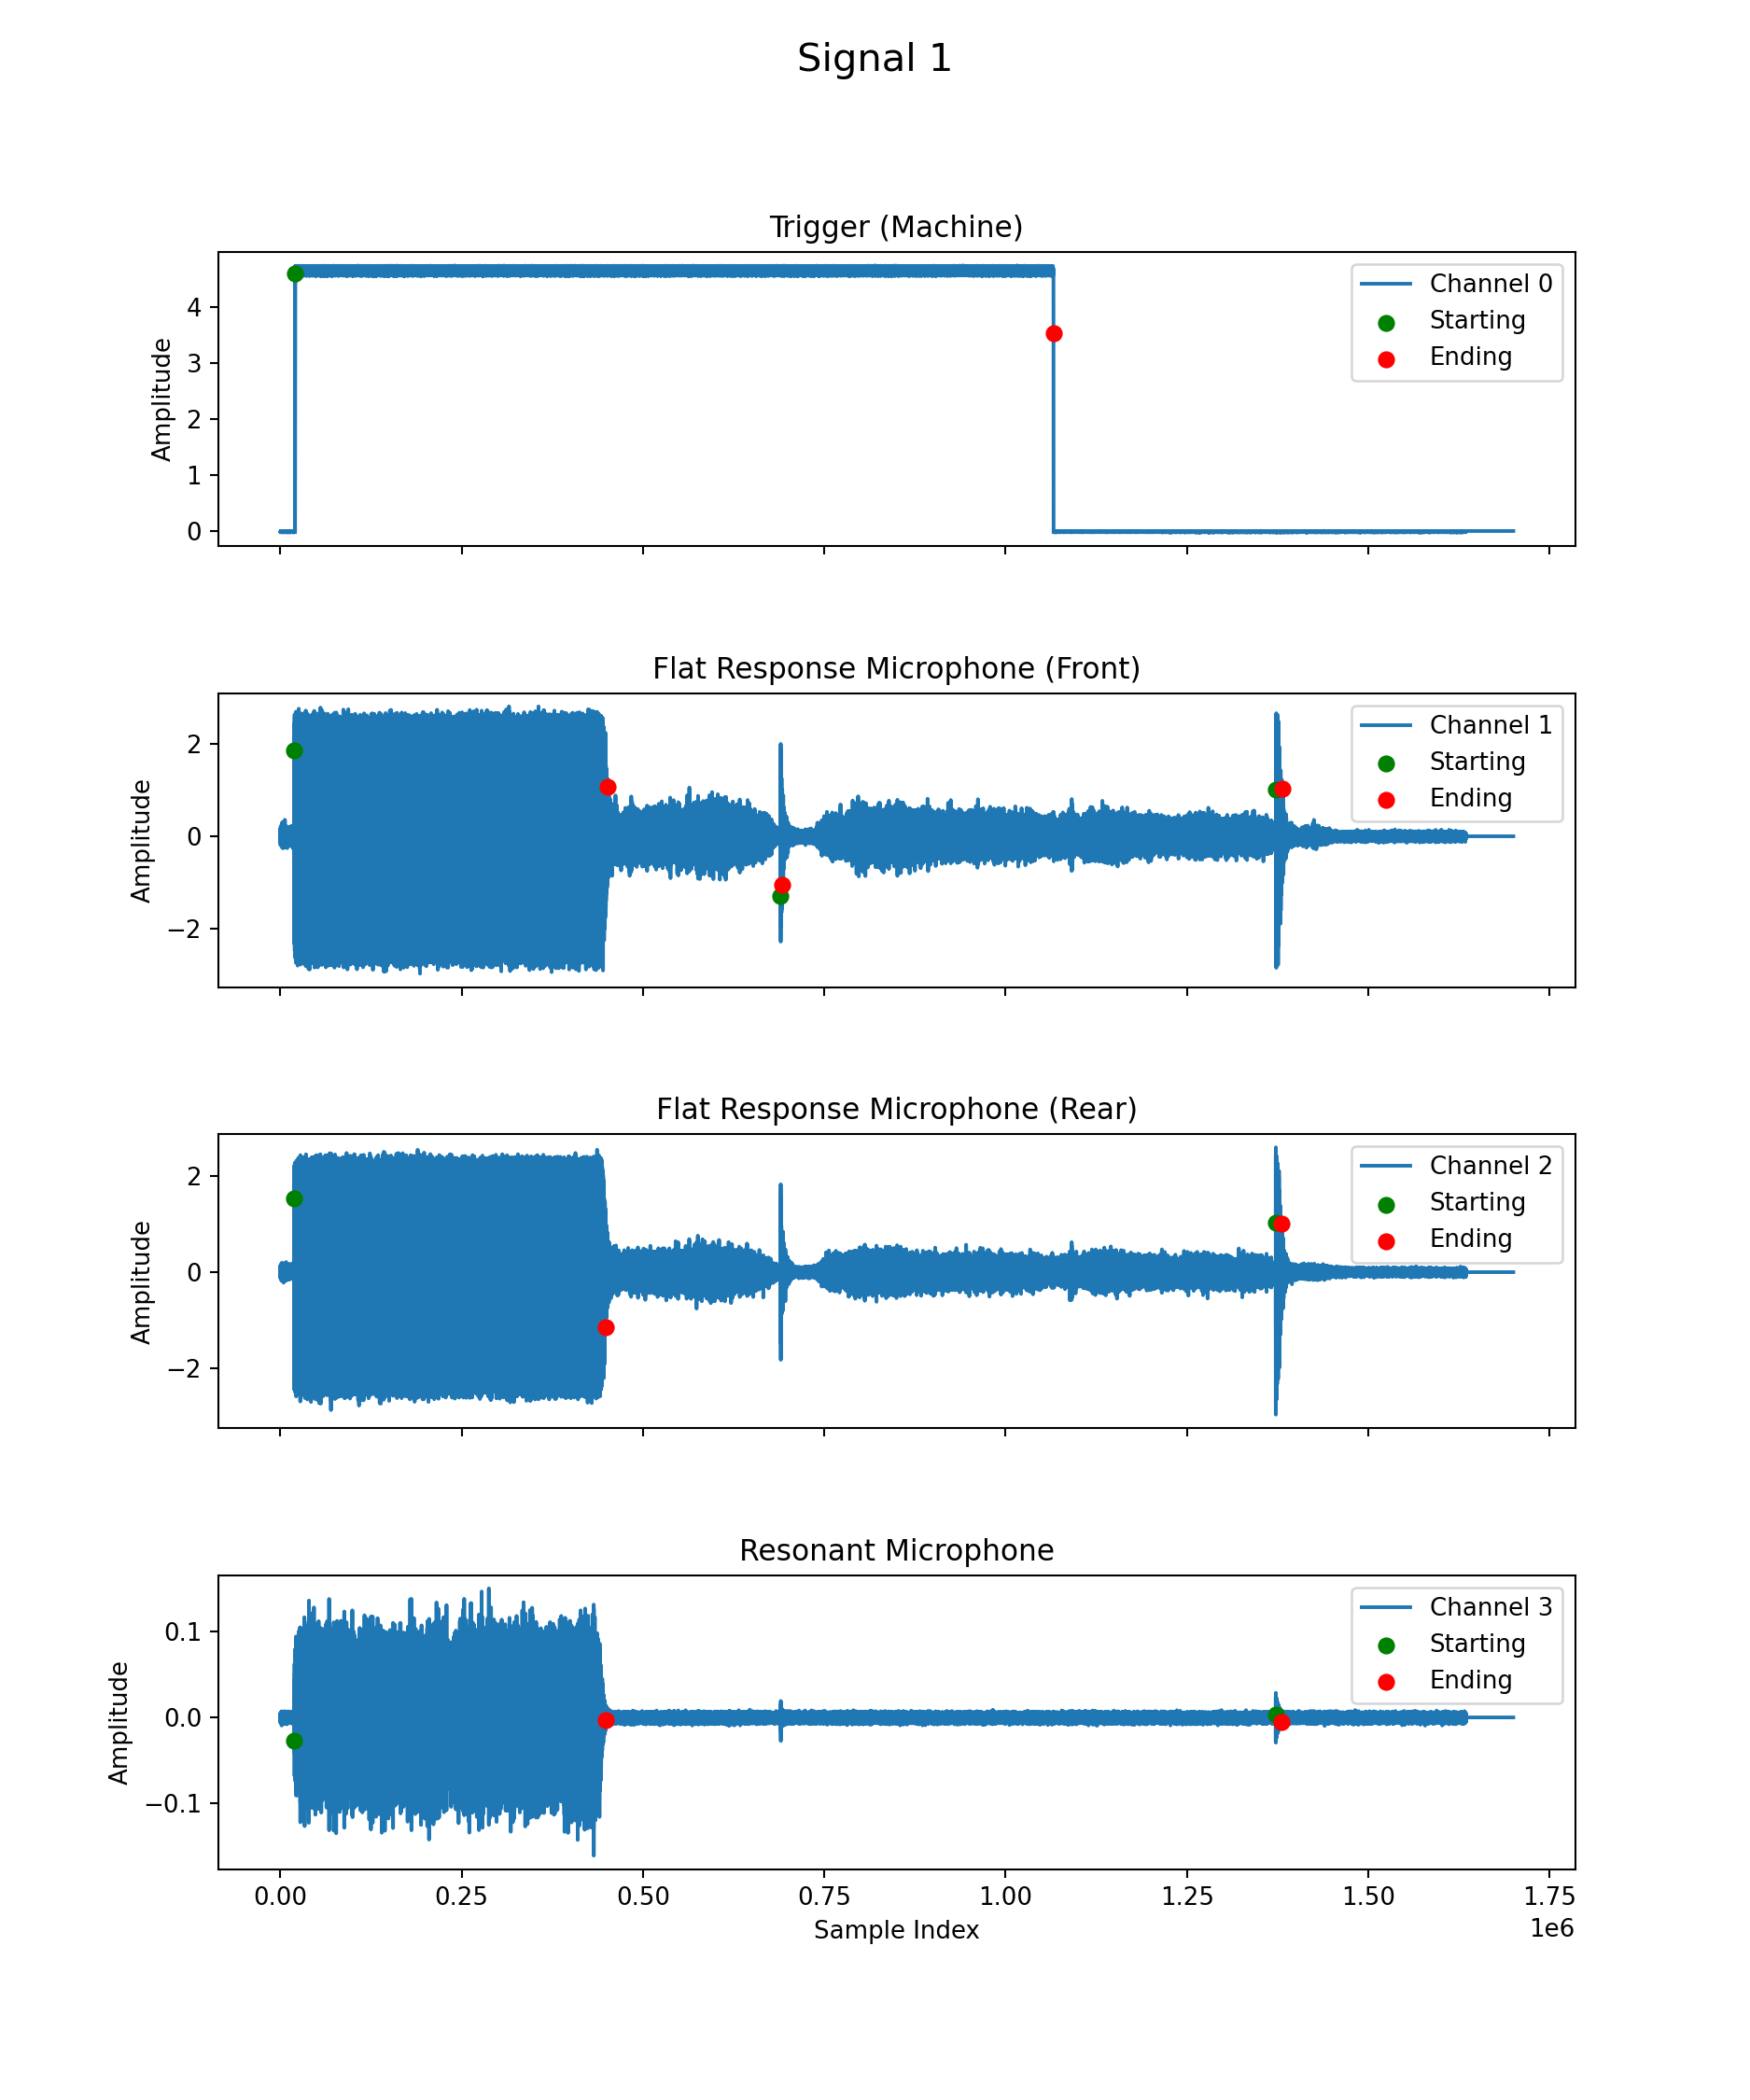

Channel 0 (Trigger (Machine)): Avg Segment Length = 1045924.00, Std Dev = 0.00, Large Gaps = 0
Channel 1 (Flat Response Microphone (Front)): Avg Segment Length = 148121.67, Std Dev = 201180.31, Large Gaps = 2
Channel 2 (Flat Response Microphone (Rear)): Avg Segment Length = 218635.50, Std Dev = 211262.50, Large Gaps = 1
Channel 3 (Resonant Microphone): Avg Segment Length = 218635.50, Std Dev = 211262.50, Large Gaps = 1
Signal 1 EXCL CH0: Avg Segment Length = 188415.29, Std Dev = 209922.33, Large Gaps EXCL CH0 = 4


<IPython.core.display.Javascript object>


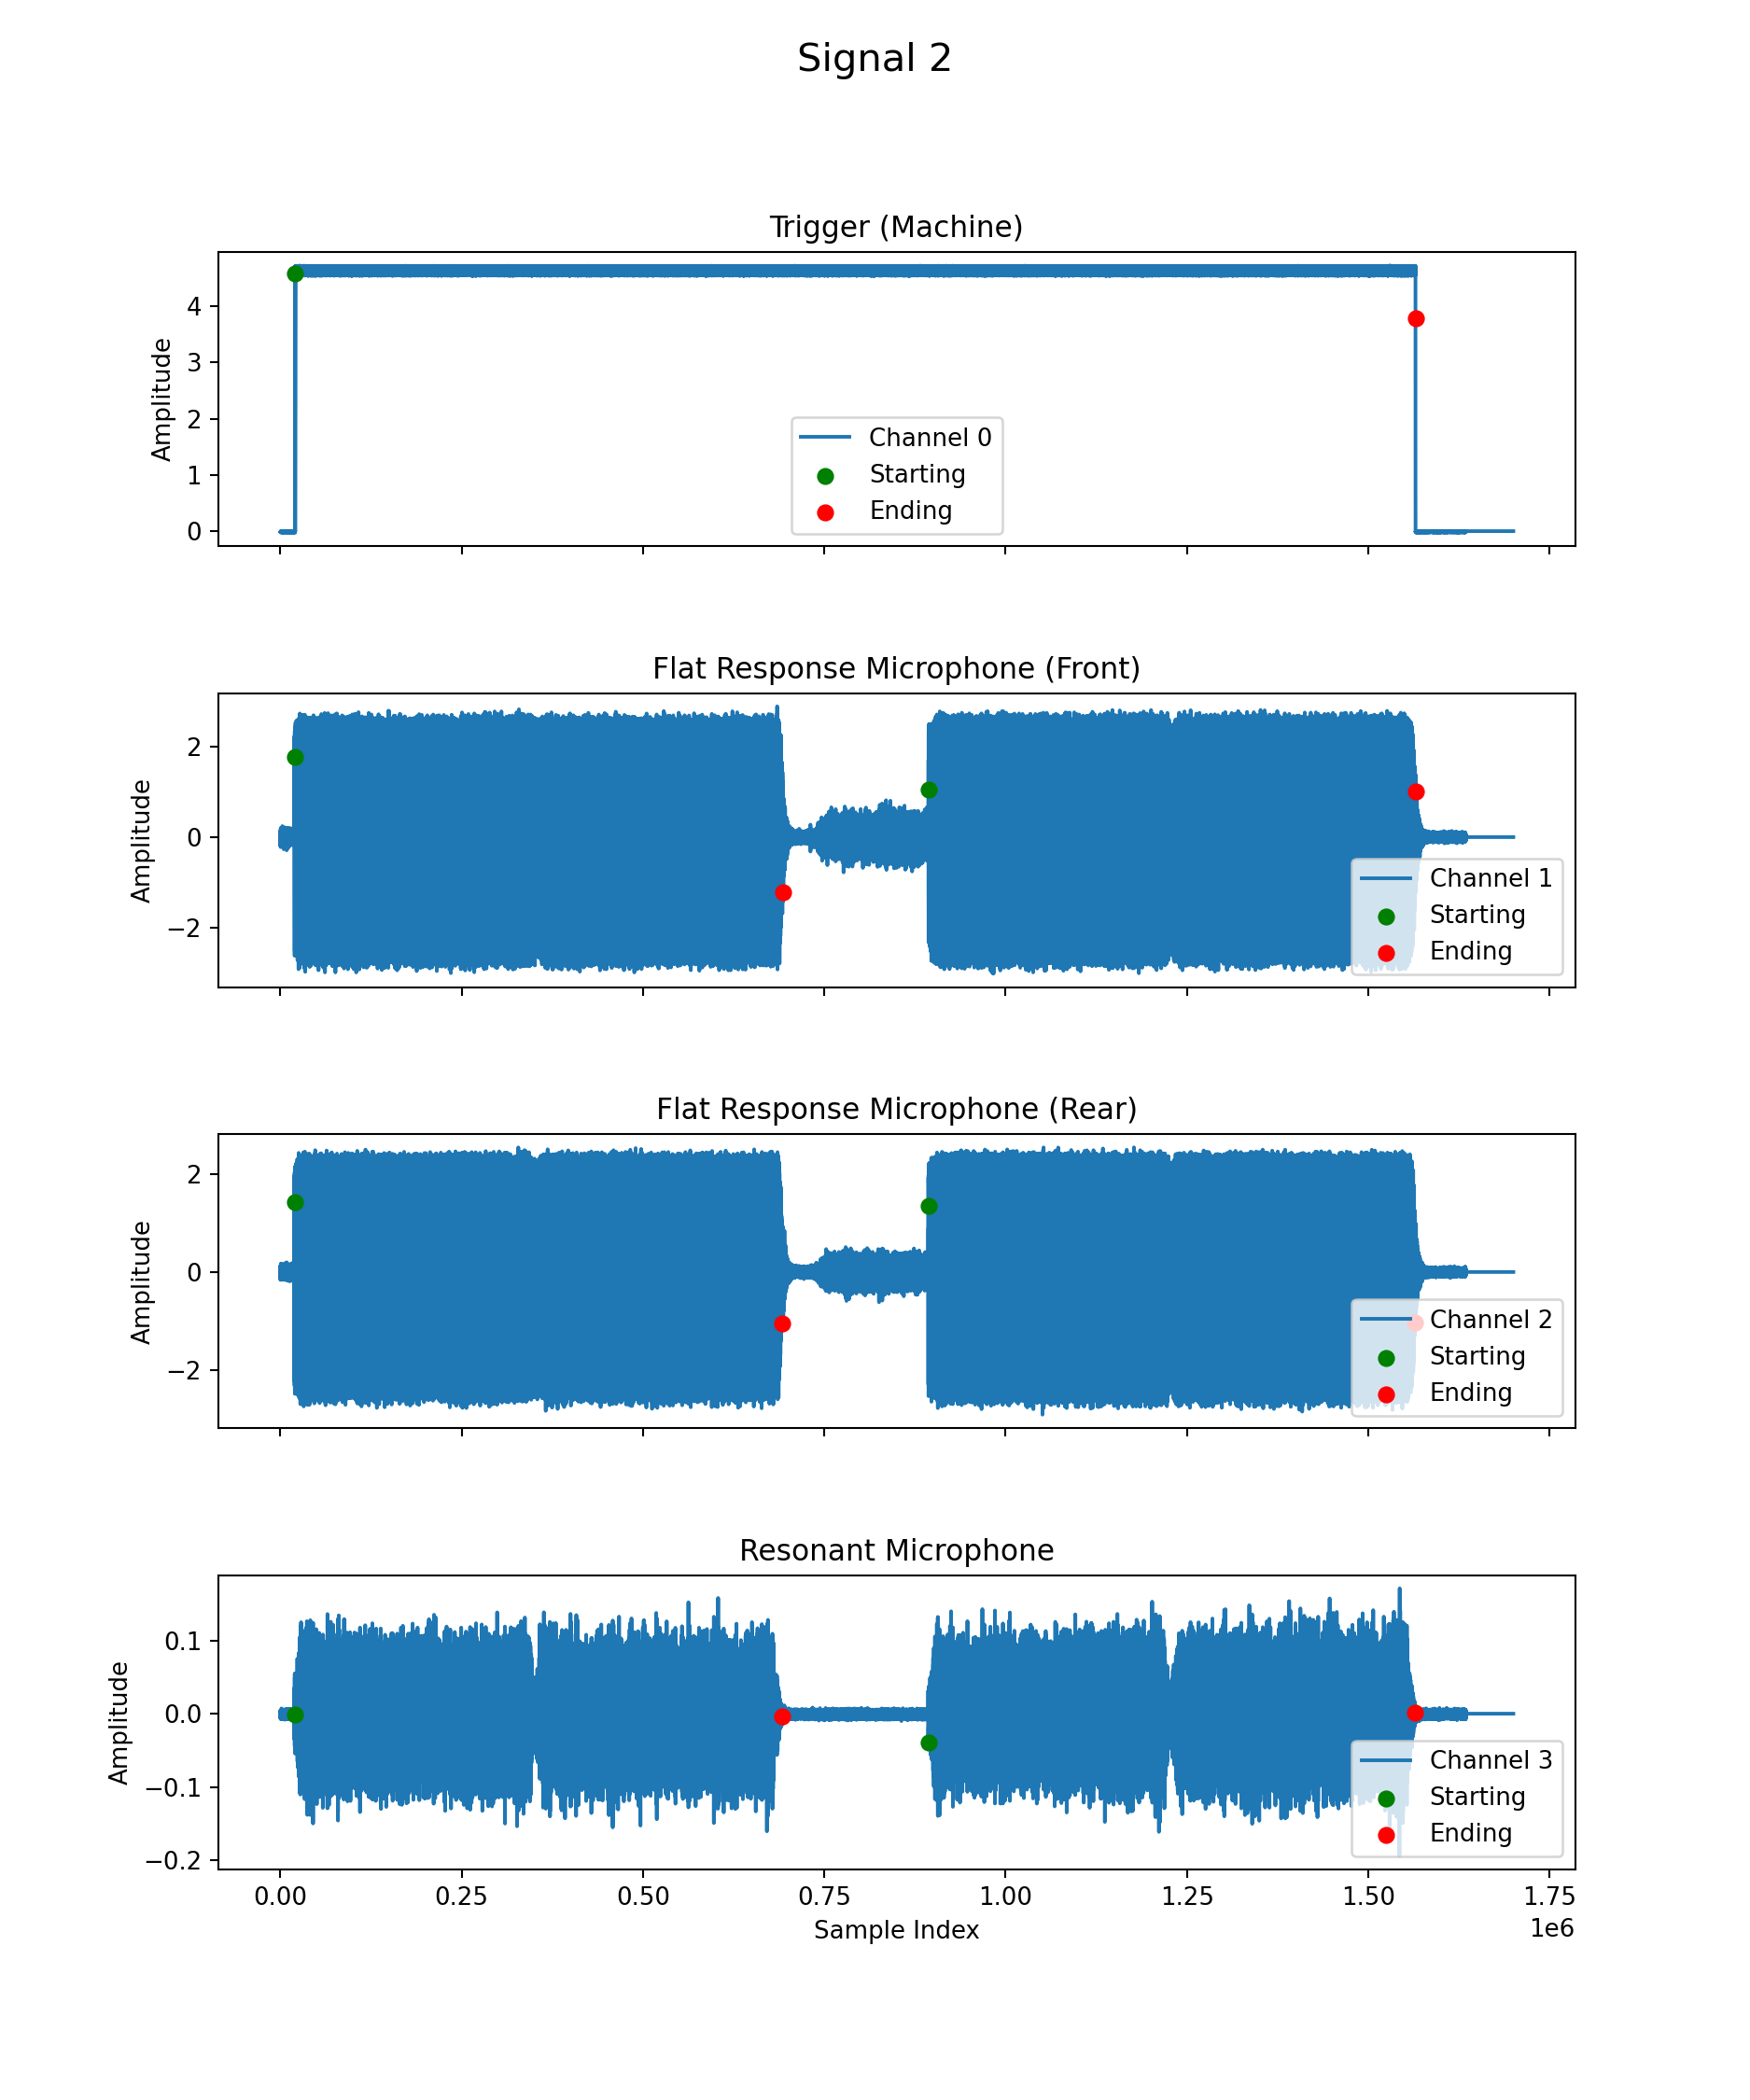

Channel 0 (Trigger (Machine)): Avg Segment Length = 1545090.00, Std Dev = 0.00, Large Gaps = 0
Channel 1 (Flat Response Microphone (Front)): Avg Segment Length = 672945.50, Std Dev = 999.50, Large Gaps = 1
Channel 2 (Flat Response Microphone (Rear)): Avg Segment Length = 671523.00, Std Dev = 457.00, Large Gaps = 1
Channel 3 (Resonant Microphone): Avg Segment Length = 671523.00, Std Dev = 457.00, Large Gaps = 1
Signal 2 EXCL CH0: Avg Segment Length = 671997.17, Std Dev = 960.16, Large Gaps EXCL CH0 = 3
All Signals EXCL CH0: Avg Segment Length = 411606.92, Std Dev = 286087.30, Total Large Gaps EXCL CH0 = 7


In [14]:
plot_signals_with_boundaries_stats_and_gaps(signals, threshold=TH)

In [15]:
def select_signals(path, N):
    """
    Select N random signals and return their data from 4 channels.
    
    :param path: The base directory where channel subdirectories are located.
    :param N: The number of random signals to select.
    :return: A list of signals, each represented by data from its 4 channels.
    """
    channels = glob.glob(os.path.join(path, "*/"))
    channels.sort()  # Ensure a consistent order of channels
    
    # Determine the total number of signals by counting files in one channel
    sample_files = glob.glob(os.path.join(channels[0], "*.parquet"))
    total_signals = len(sample_files)
    
    
    selected_signal_numbers = N
    
    selected_signals_data = []
    for num in selected_signal_numbers:
        signal_data = []
        for channel in channels:
            file_name = f"File_{num}.parquet"
            signal_file_path = os.path.join(channel, file_name)
            
            if os.path.exists(signal_file_path):
                # Read the Parquet file and append the DataFrame to the signal_data list
                df = pd.read_parquet(signal_file_path)
                signal_data.append(df)
            else:
                print(f"File not found: {signal_file_path}")
                # Optionally, handle missing files (e.g., append None or an empty DataFrame)
                signal_data.append(None)
                
        # Append the list of DataFrames (one per channel) for the current signal to the results list
        selected_signals_data.append(signal_data)
    
    return selected_signals_data


In [ ]:
problematic_signal = select_signals(data_path, [322,323,324,325])

In [ ]:
plot_signals_with_boundaries_stats_and_gaps(problematic_signal, threshold=1.5)